# Master Thesis Notebook

## Setup

/Users/jverbois/python_gab/Master-Thesis/classes.py:786: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


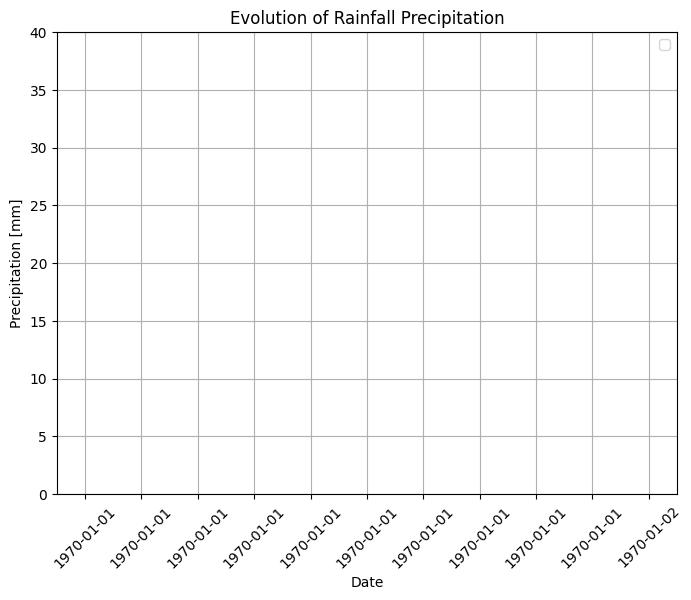

In [1]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Raw data

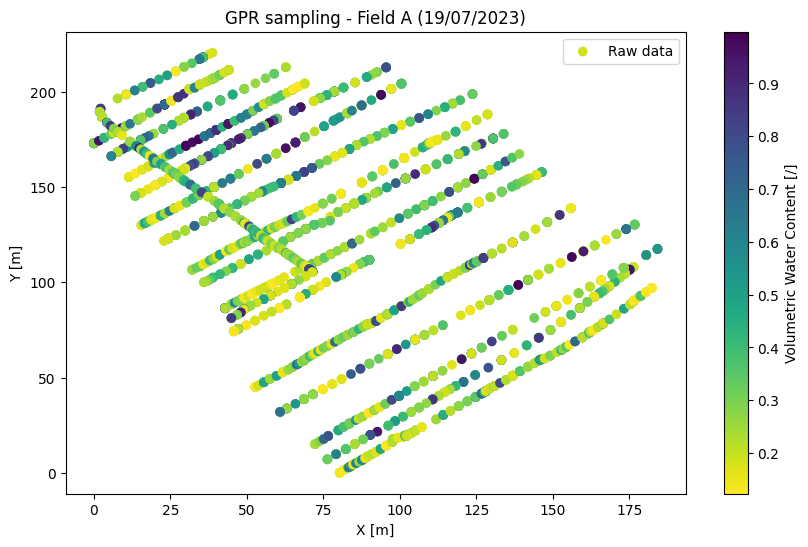

In [2]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=4)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data()

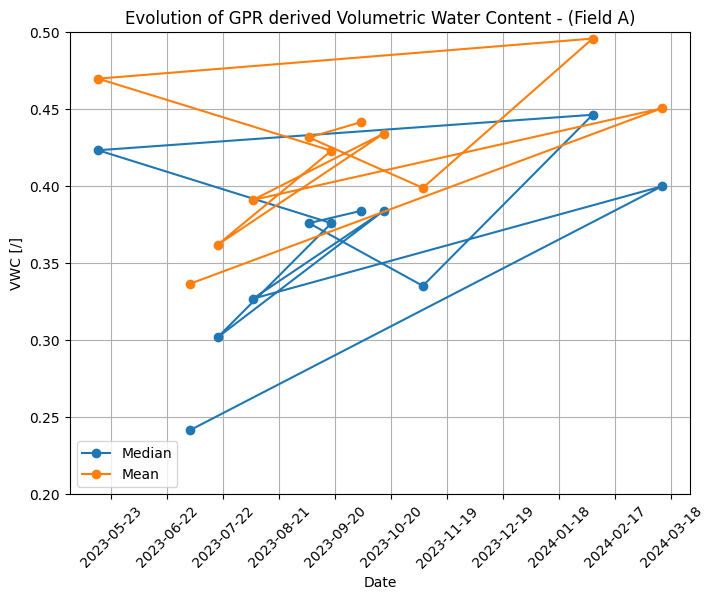

In [6]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

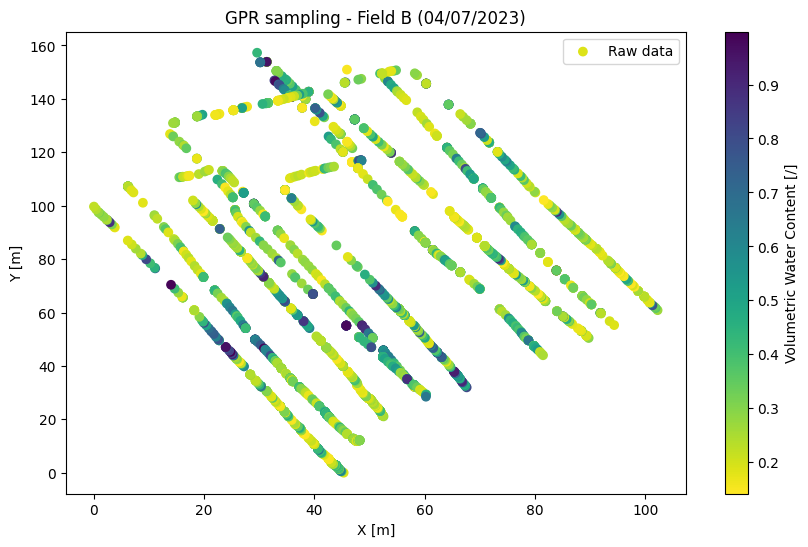

In [7]:
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data()

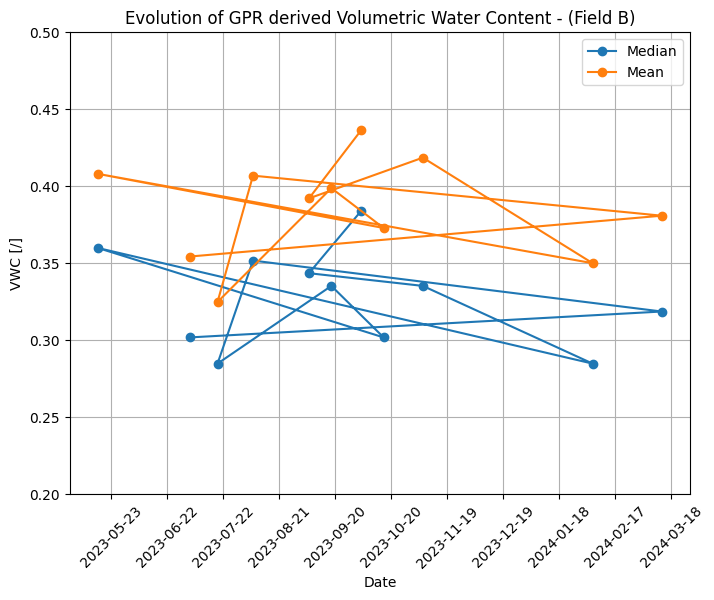

In [8]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

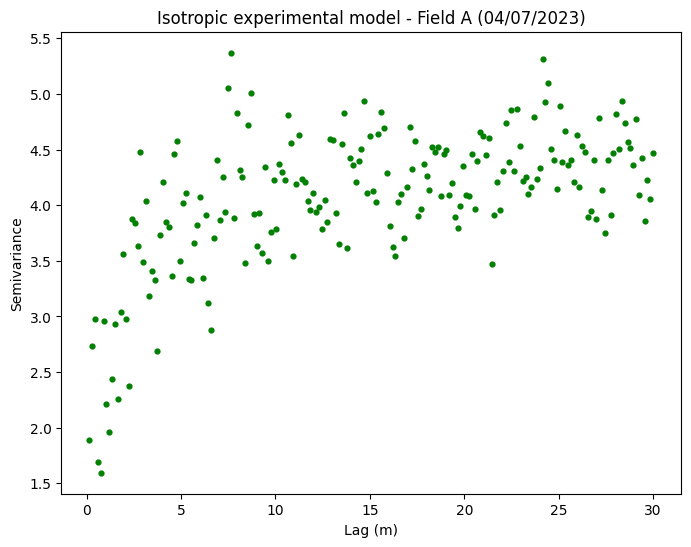

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999895,  0.2999979 ,  0.44999684,  0.59999579,  0.74999474,
         0.89999369,  1.04999264,  1.19999159,  1.34999053,  1.49998948,
         1.64998843,  1.79998738,  1.94998633,  2.09998528,  2.24998422,
         2.39998317,  2.54998212,  2.69998107,  2.84998002,  2.99997897,
         3.14997791,  3.29997686,  3.44997581,  3.59997476,  3.74997371,
         3.89997266,  4.0499716 ,  4.19997055,  4.3499695 ,  4.49996845,
         4.6499674 ,  4.79996635,  4.94996529,  5.09996424,  5.24996319,
         5.39996214,  5.54996109,  5.69996004,  5.84995898,  5.99995793,
         6.14995688,  6.29995583,  6.44995478,  6.59995373,  6.74995267,
         6.89995162,  7.04995057,  7.19994952,  7.34994847,  7.49994742,
         7.64994636,  7.79994531,  7.94994426,  8.09994321,  8.24994216,
         8.39994111,  8.54994005,  8.699939  ,  8.84993795,  8.9999369 ,
         9.14993585,  9.2999348 ,  9.44993374,  9.59993269,  9.74993164,
  

In [9]:
experimental_vario_a = Variogram(resolution=0.00002, field_letter="A", sample_number=0)

experimental_vario_a.determ_experimental_vario()
# ; hide output of the cell

In [10]:
experimental_vario_a.fit_models()

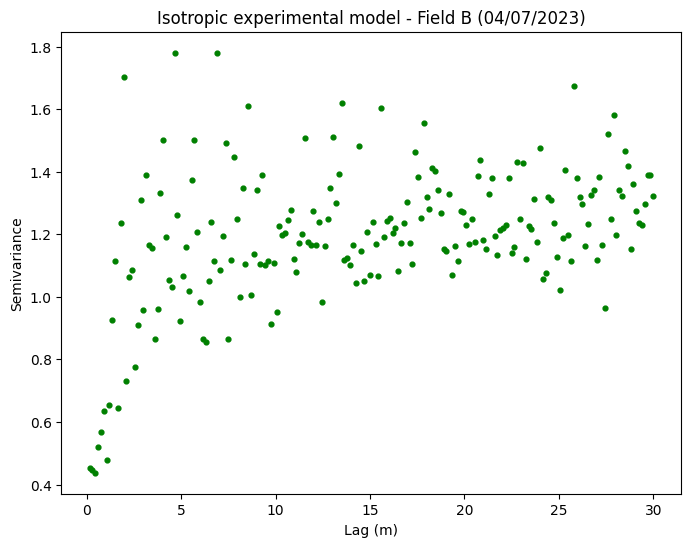

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999887,  0.29999774,  0.44999662,  0.59999549,  0.74999436,
         0.89999323,  1.0499921 ,  1.19999098,  1.34998985,  1.49998872,
         1.64998759,  1.79998647,  1.94998534,  2.09998421,  2.24998308,
         2.39998195,  2.54998083,  2.6999797 ,  2.84997857,  2.99997744,
         3.14997631,  3.29997519,  3.44997406,  3.59997293,  3.7499718 ,
         3.89997068,  4.04996955,  4.19996842,  4.34996729,  4.49996616,
         4.64996504,  4.79996391,  4.94996278,  5.09996165,  5.24996052,
         5.3999594 ,  5.54995827,  5.69995714,  5.84995601,  5.99995489,
         6.14995376,  6.29995263,  6.4499515 ,  6.59995037,  6.74994925,
         6.89994812,  7.04994699,  7.19994586,  7.34994473,  7.49994361,
         7.64994248,  7.79994135,  7.94994022,  8.0999391 ,  8.24993797,
         8.39993684,  8.54993571,  8.69993458,  8.84993346,  8.99993233,
         9.1499312 ,  9.29993007,  9.44992894,  9.59992782,  9.74992669,
  

In [ ]:
experimental_vario_b = Variogram(resolution=0.00002, field_letter="B", sample_number=0)

experimental_vario_b.determ_experimental_vario()
# ; hide output of the cell

In [ ]:
experimental_vario_b.fit_models()

KeyboardInterrupt: 

### Kriged data

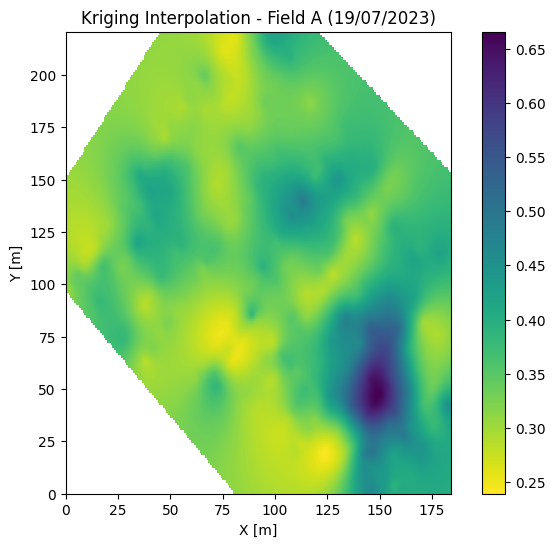

(1, 1)

In [3]:
gpr_a.kriging(x_grid_step=1, y_grid_step=1, plot=True)

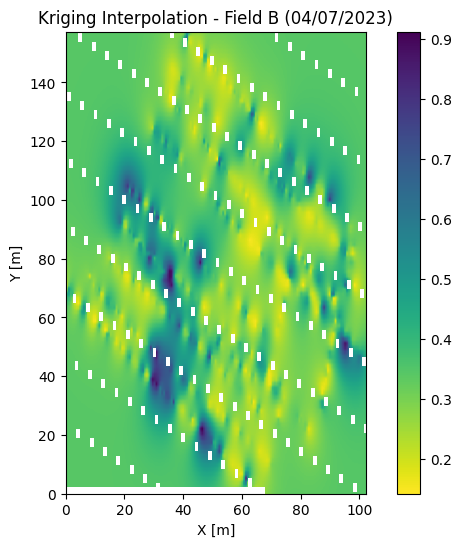

(1, 1)

In [ ]:
gpr_b.kriging(x_grid_step=1, y_grid_step=1, plot=True)

## TDR Verification

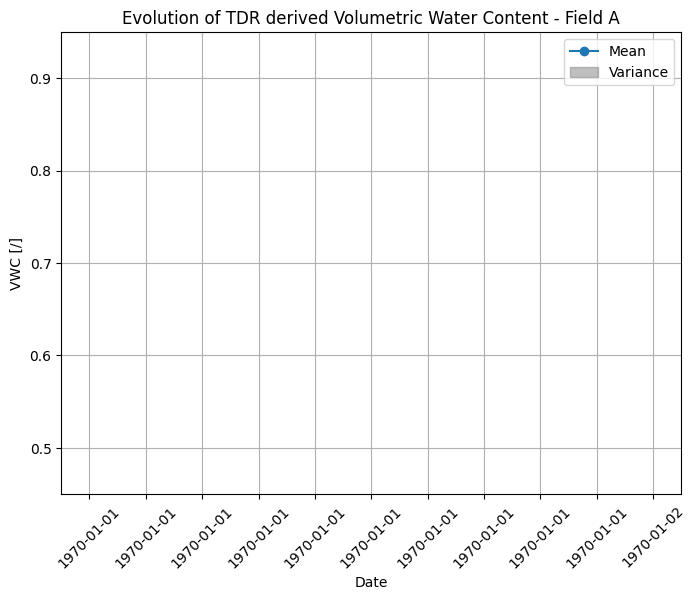

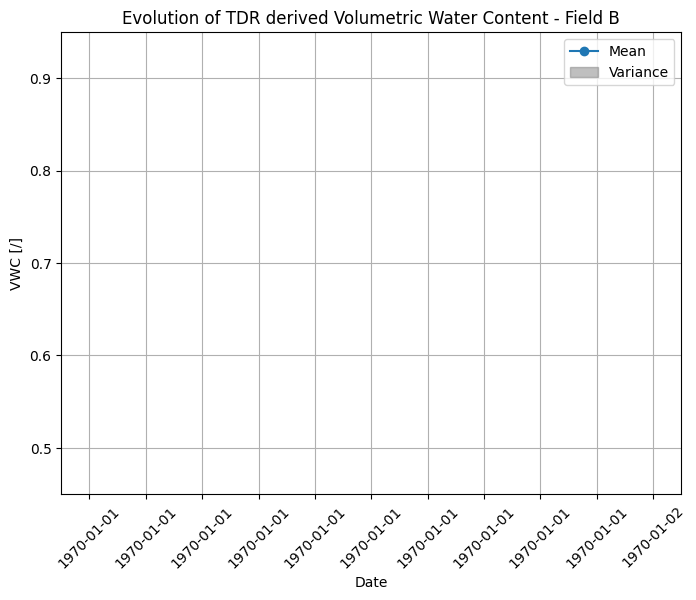

In [ ]:
test = TdrAnalysis()
test.plot_tdr_evolution()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()

RasterioIOError: D:/Cours bioingé/BIR M2/Mémoire/Data/thermal/MR20240205_georeferenced_thermal_cali.tif: No such file or directory